In [ ]:
# Imports
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, XGate

from qiskit_algorithms import optimizers
from qiskit.primitives import Estimator

from qiskit import *
from qiskit.visualization import *
from qiskit_aer import Aer

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.properties import ParticleNumber

In [ ]:
# =================================================================
# ====================== Get data from the files ==================
# =================================================================

# ================= Hamiltonian =====================

with open("data/hamiltonian.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print("===================================================")
print(f"Hamiltoniano: \n{hamiltonian}")
print("===================================================\n")


# ================= Nuclear repulsion ===============

with open("data/nuclear_repulsion.pkl", "rb") as f:
    nuclear_repulsion = pickle.load(f)

print("===================================================")
print(f"Energía nuclear: {nuclear_repulsion}")
print("===================================================\n")


# ================= Ansatz =====================

with open("data/ansatz.pkl", "rb") as f:
    ansatz= pickle.load(f)

Hamiltoniano: 
SparsePauliOp(['IIIIIIIIIIIIII', 'IIIIIIIIIIIIIZ', 'IIIIIIIIIIIIYY', 'IIIIIIIIIIIIXX', 'IIIIIIIIIIYZZY', 'IIIIIIIIIIXZZX', 'IIIIIIIIYZZZZY', 'IIIIIIIIXZZZZX', 'IIIIIIIIIIIIZI', 'IIIIIIIIIIYZYI', 'IIIIIIIIIIXZXI', 'IIIIIIIIYZZZYI', 'IIIIIIIIXZZZXI', 'IIIIIIIIIIIZII', 'IIIIIIIYZZZYII', 'IIIIIIIXZZZXII', 'IIIIIIIIIIZIII', 'IIIIIIIIYZYIII', 'IIIIIIIIXZXIII', 'IIIIIIIIIZIIII', 'IIIIIIIIZIIIII', 'IIIIIIIZIIIIII', 'IIIIIIZIIIIIII', 'IIIIIYYIIIIIII', 'IIIIIXXIIIIIII', 'IIIYZZYIIIIIII', 'IIIXZZXIIIIIII', 'IYZZZZYIIIIIII', 'IXZZZZXIIIIIII', 'IIIIIZIIIIIIII', 'IIIYZYIIIIIIII', 'IIIXZXIIIIIIII', 'IYZZZYIIIIIIII', 'IXZZZXIIIIIIII', 'IIIIZIIIIIIIII', 'YZZZYIIIIIIIII', 'XZZZXIIIIIIIII', 'IIIZIIIIIIIIII', 'IYZYIIIIIIIIII', 'IXZXIIIIIIIIII', 'IIZIIIIIIIIIII', 'IZIIIIIIIIIIII', 'ZIIIIIIIIIIIII', 'IIIIIIIIIIIIZZ', 'IIIIIIIIIIYZYZ', 'IIIIIIIIIIXZXZ', 'IIIIIIIIYZZZYZ', 'IIIIIIIIXZZZXZ', 'IIIIIIIIIIIZIZ', 'IIIIIIIYZZZYIZ', 'IIIIIIIXZZZXIZ', 'IIIIIIIIIIZIIZ', 'IIIIIIIIYZYIIZ', 'IIIIIIIIXZXIIZ'

Iteración 1: Energía = -84.15685981709274
Iteración 2: Energía = -69.94159901258465
Iteración 3: Energía = -69.8988647342391
Iteración 4: Energía = -83.19271327926104
Iteración 5: Energía = -83.13142199288215
Iteración 6: Energía = -83.64501367367595
Iteración 7: Energía = -83.51836421865146
Iteración 8: Energía = -83.74748981670686
Iteración 9: Energía = -83.69244948115104
Iteración 10: Energía = -83.84072666529285
Iteración 11: Energía = -83.77960962016354
Iteración 12: Energía = -69.94159901258453
Iteración 13: Energía = -69.89886473423893
Iteración 14: Energía = -83.192713279261
Iteración 15: Energía = -83.13142199288195
Iteración 16: Energía = -83.64501367367575
Iteración 17: Energía = -83.51836421865119
Iteración 18: Energía = -83.74748981670682
Iteración 19: Energía = -83.69244948115092
Iteración 20: Energía = -83.84072666529275
Iteración 21: Energía = -83.77960962016344
Iteración 22: Energía = -68.88966332739875
Iteración 23: Energía = -69.38957826862327
Iteración 24: Energía =

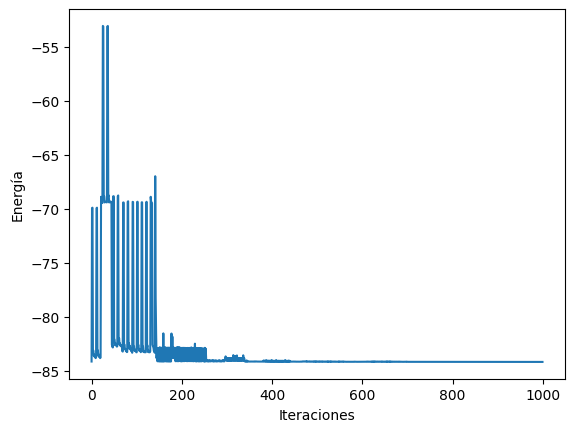

In [ ]:
# Local simulator
simulator = Aer.get_backend('qasm_simulator')

# Parameter initialization
x0 = np.zeros(ansatz.num_parameters)

# Diccionario para almacenar la evolución del costo
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

# Función de coste
def cost_func(params, ansatz, hamiltonian, estimator):
    job = estimator.run([ansatz], [hamiltonian], [params])
    result = job.result()
    energy = result.values[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)

    print(f"Iteración {cost_history_dict['iters']}: Energía = {energy}")

    return energy

# Creamos el estimador para el simulador
estimator = Estimator()

# Ejecutamos la optimización
res = minimize(
    cost_func,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="COBYLA",
)

# Resultado final
print("Parámetros óptimos:", res.x)
print("Energía mínima encontrada:", res.fun)

# Graficar evolución del costo
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Energía")
plt.show()

In [ ]:
# energy = -82.74018905934595 + nuclear_repulsion
energy = res.fun + nuclear_repulsion
print(f"Energía total: {energy}")

Energía nuclear: 9.193913160623385
Energía total: -74.99997897148256


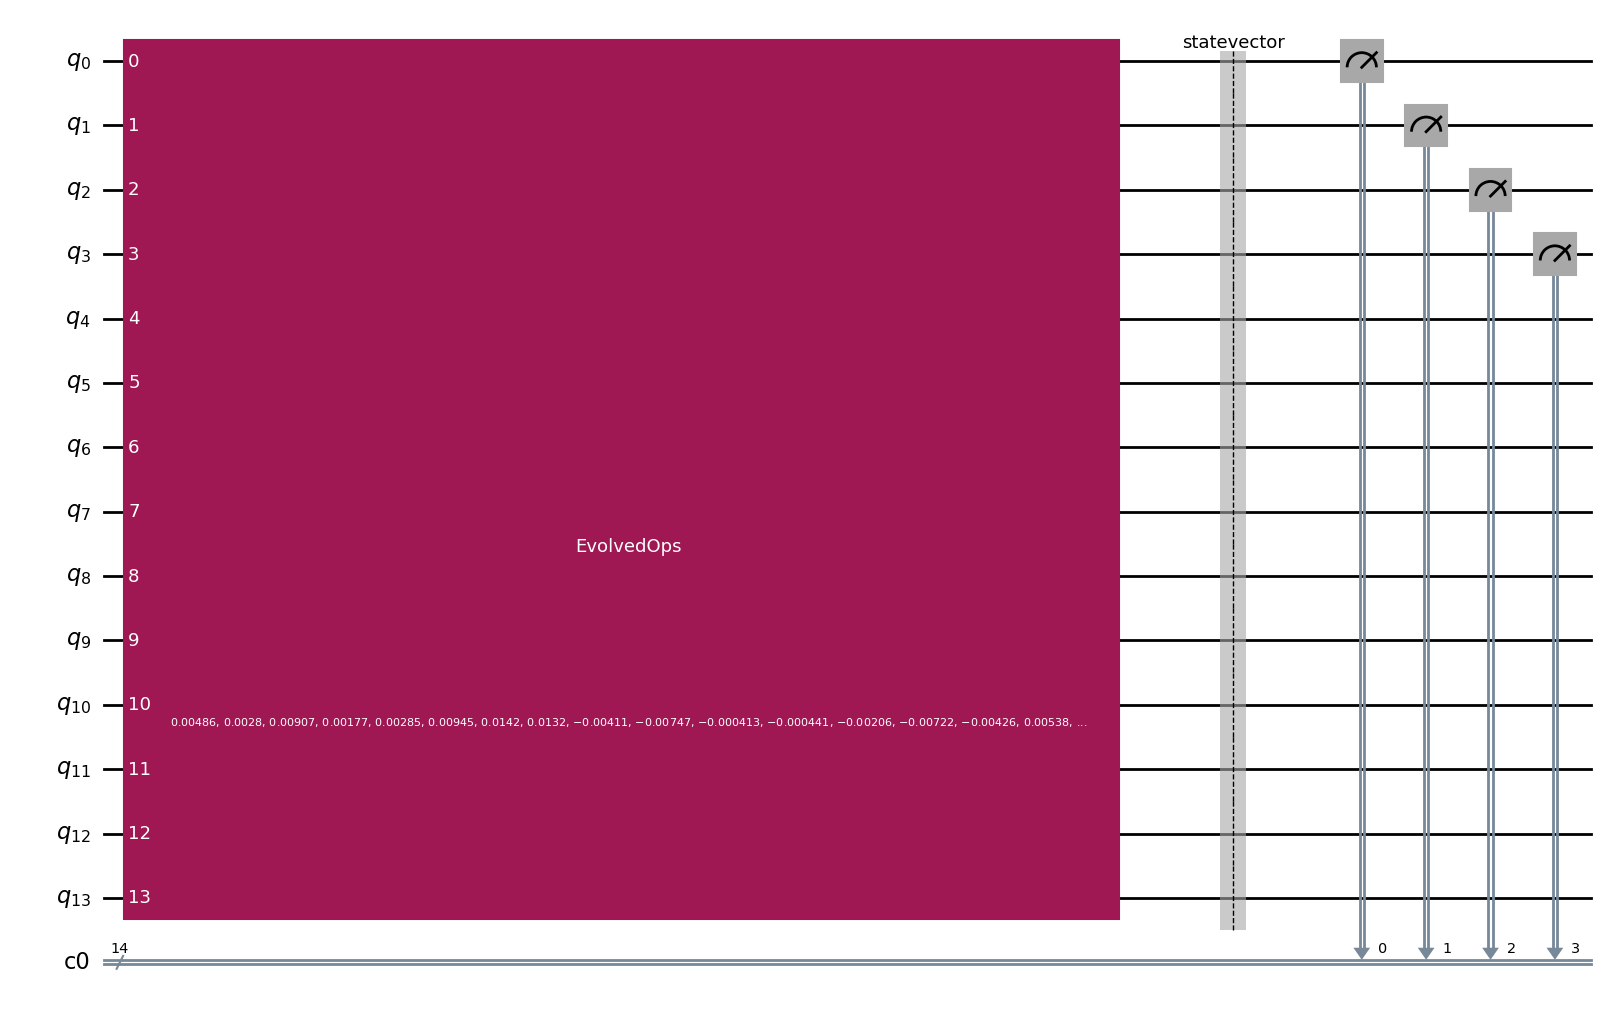

In [ ]:
# Estado cuántico

qc_bound = ansatz.assign_parameters({list(ansatz.parameters)[i]: res.x[i] for i in range(len(res.x))}) # Asignamos los parámetros al circuito

c_reg = ClassicalRegister(ansatz.num_qubits) # Añadimos un bit clásico a qc_bound
qc_bound.add_register(c_reg)

qc_bound.save_statevector() # Guardamos el estado antes de la medida

qc_bound.measure(range(4),range(4)) # Medimos

qc_bound.draw("mpl", style="iqp") # Dibujamos

Statevector([-3.79397928e-33+3.82114068e-33j,
              1.35998658e-32-1.41939931e-32j,
             -2.85984649e-34+6.89830926e-33j, ...,
             -1.65068875e-17+7.64528591e-18j,
             -2.93367168e-17-9.03924582e-17j,
              2.32206475e-16-2.72425169e-16j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))


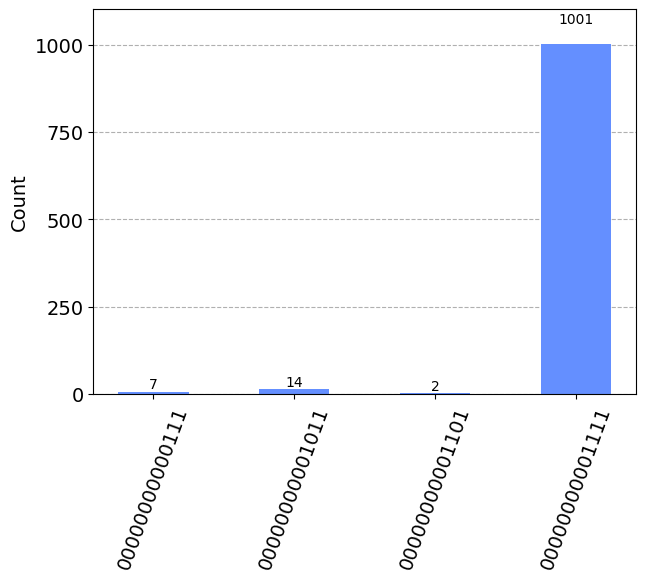

In [26]:
# Simulamos

sim = Aer.get_backend('qasm_simulator')
my_circuit = transpile(qc_bound, sim)
job = sim.run(my_circuit)
result = job.result()

sv = result.get_statevector()
print(sv)

counts = result.get_counts()
plot_histogram(counts)